# Building extraction from historical map using SVM classifier in Python


## Data Wrangling and Preparation

### Mounting Google Drive

In [22]:
#from google.colab import drive
#drive.mount('/content/drive')

### Install Dependencies

In [23]:
!pip install rasterio geopandas shapely

### Loading libraries


In [24]:
import os
import rasterio
from rasterio.mask import mask
from skimage import io, color, exposure
import geopandas as gpd
import numpy as np
import cv2
from matplotlib import pyplot
from shapely.geometry import mapping


### Loading Data

In [25]:
!wget https://drive.google.com/uc?id=1G1--4hO5vlUSH9xEGRPH_CGbTJ5XduF5 -O jogja.tif
#!wget https://github.com/danylaksono/historical-map-extraction/blob/main/Data/jogja_10000_1925.tif -O jogja.tif

!wget https://github.com/danylaksono/historical-map-extraction/blob/main/Data/clipper.zip -O clipper.zip


--2020-11-09 17:44:21--  https://drive.google.com/uc?id=1G1--4hO5vlUSH9xEGRPH_CGbTJ5XduF5
Resolving drive.google.com (drive.google.com)... 74.125.20.113, 74.125.20.102, 74.125.20.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.20.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-7c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v5o678l0h90r63log297bbhmbj4qr0uu/1604943825000/10973890960709691040/*/1G1--4hO5vlUSH9xEGRPH_CGbTJ5XduF5 [following]
--2020-11-09 17:44:22--  https://doc-0o-7c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/v5o678l0h90r63log297bbhmbj4qr0uu/1604943825000/10973890960709691040/*/1G1--4hO5vlUSH9xEGRPH_CGbTJ5XduF5
Resolving doc-0o-7c-docs.googleusercontent.com (doc-0o-7c-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0o-7c-docs.googleusercontent.com (doc-0o-7c-docs.googleusercontent.com)|74.125.195

### Display the map

EPSG:4326
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 5002, 'height': 4463, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.6250758479900898e-05, 0.0, 110.32798548245933,
       0.0, -1.6250758479900898e-05, -7.760966807896364)}


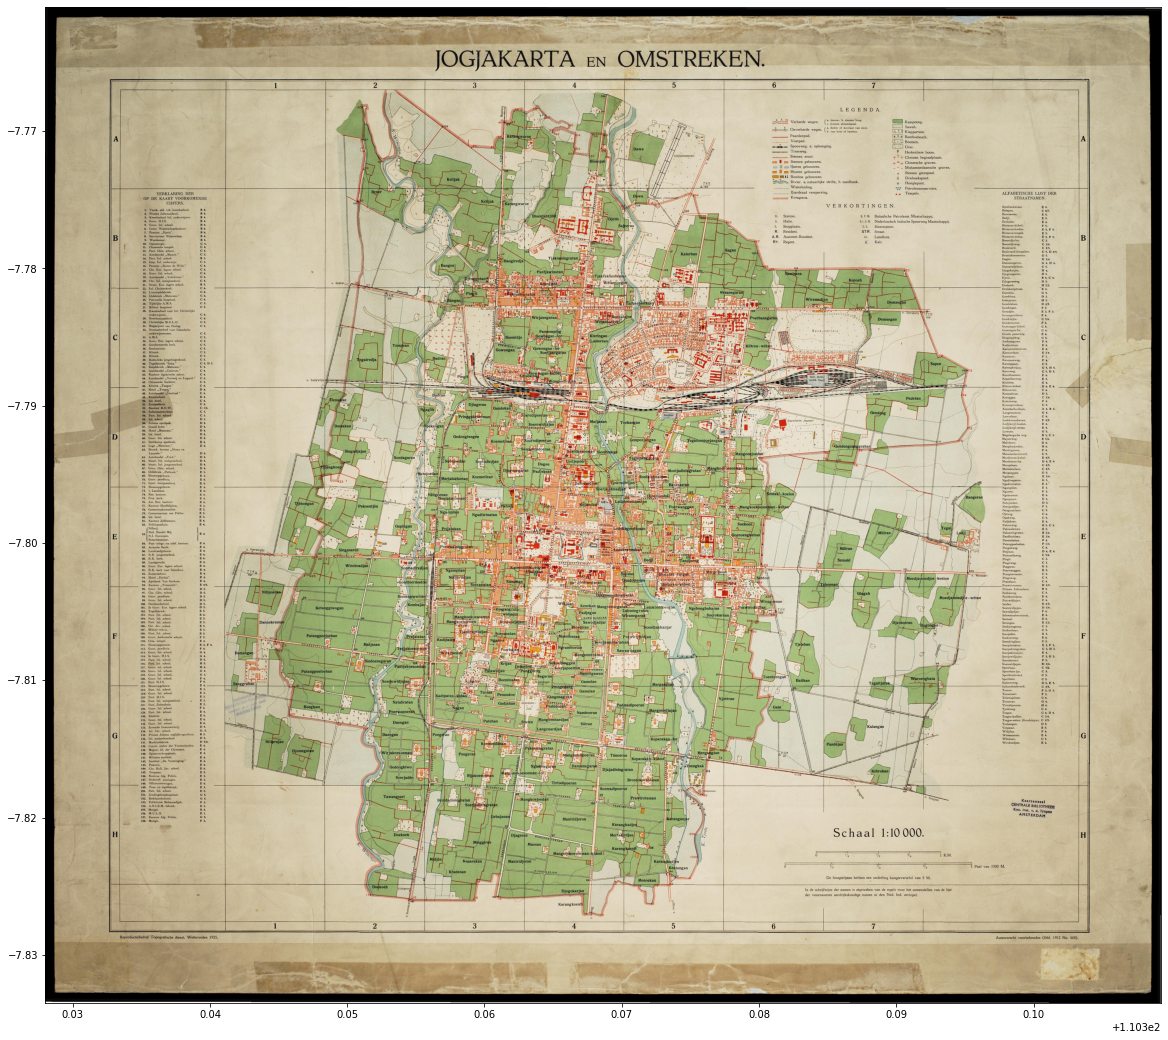

In [26]:
from matplotlib import pyplot as plt
from rasterio.plot import show

# enlarge the plot
plt.rcParams["figure.figsize"] = (20,20)


# calling the image as source
# python 'with' ensures that the file is closed after the iteration
with rasterio.open("jogja.tif") as src:
  # checking the loaded data
  print(src.crs)
  print(src.meta)
  show(src.read(), transform=src.transform)

### Clip the map

In [27]:
url = 'https://raw.githubusercontent.com/danylaksono/historical-map-extraction/main/Data/clipper.geojson'
shapes = gpd.read_file(url)
print(shapes.head())

                                            geometry
0  POLYGON ((110.34141 -7.76636, 110.34120 -7.828...


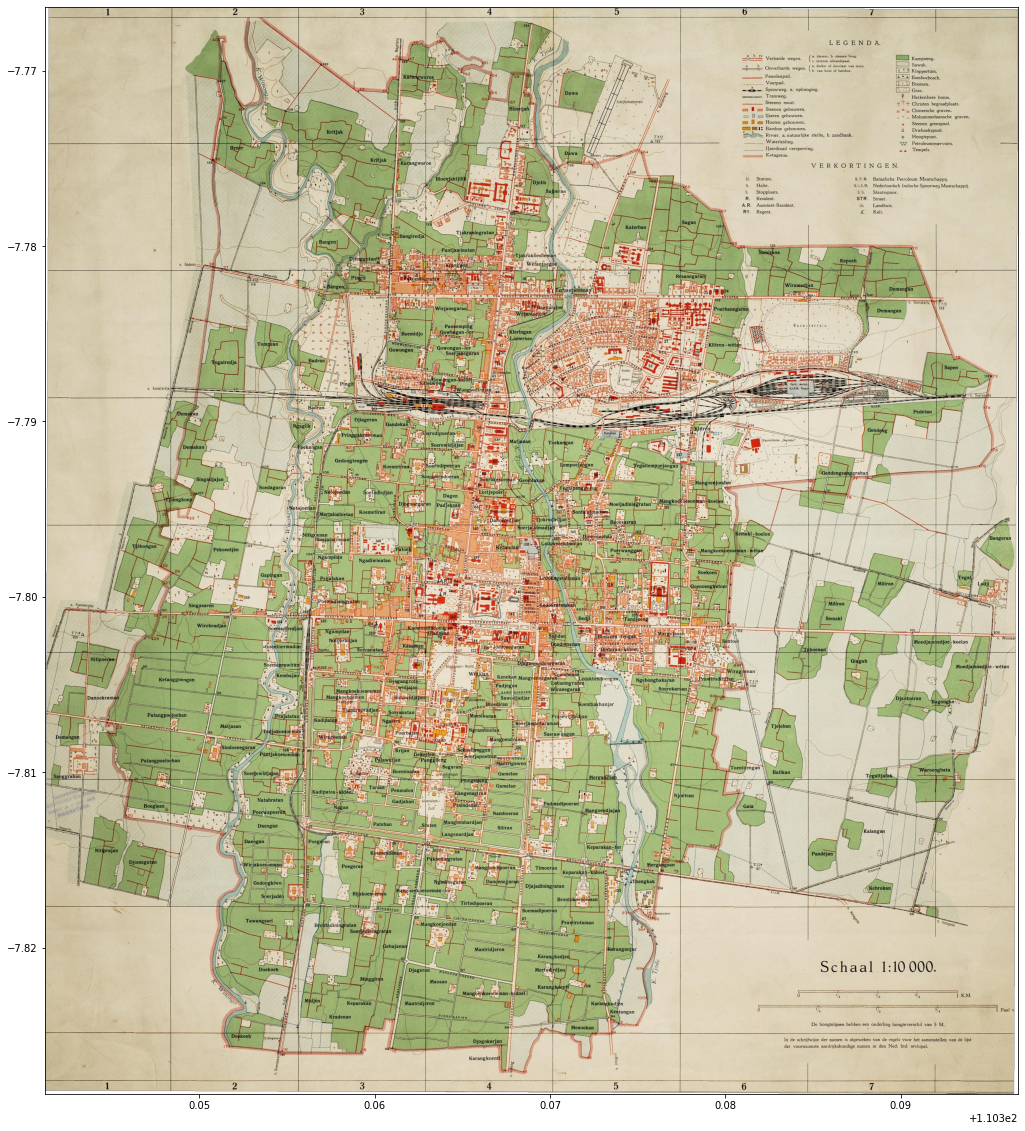

In [28]:
# clip the image
with rasterio.open("jogja.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes.geometry, crop=True)
    out_meta = src.meta
    
# update metadata for writing
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# write the clipped image
with rasterio.open("jogja_clipped.tif", "w", **out_meta) as dest:
    dest.write(out_image)

# show clipped map
clippedsrc = rasterio.open("jogja_clipped.tif")
show(clippedsrc.read(), transform=clippedsrc.transform)

In [29]:
print(clippedsrc.height)
print(clippedsrc.width)


3815
3414


In [30]:
#clippedsrc.close()

## Image Classification with Machine Learning

### Preparing data

(3, 500, 1200)


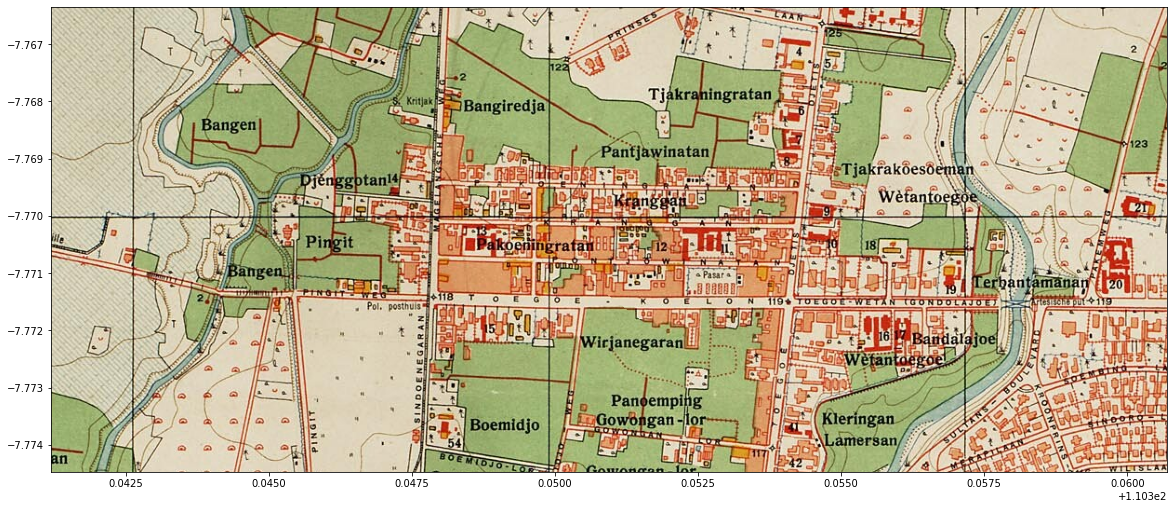

In [38]:
import matplotlib.pyplot as plt
from rasterio.plot import show

clipped_img = clippedsrc.read([1,2,3])[:, 700:1200, 800:2000]

print(clipped_img.shape)
fig, ax = plt.subplots(figsize=(20,17))
show(clipped_img[:, :, :], ax=ax, transform=clippedsrc.transform)

In [ ]:
!wget https://github.com/danylaksono/historical-map-extraction/blob/main/Data/training.geojson -O training.geojson

In [39]:
training = gpd.read_file('https://raw.githubusercontent.com/danylaksono/historical-map-extraction/main/Data/training.geojson')
training.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

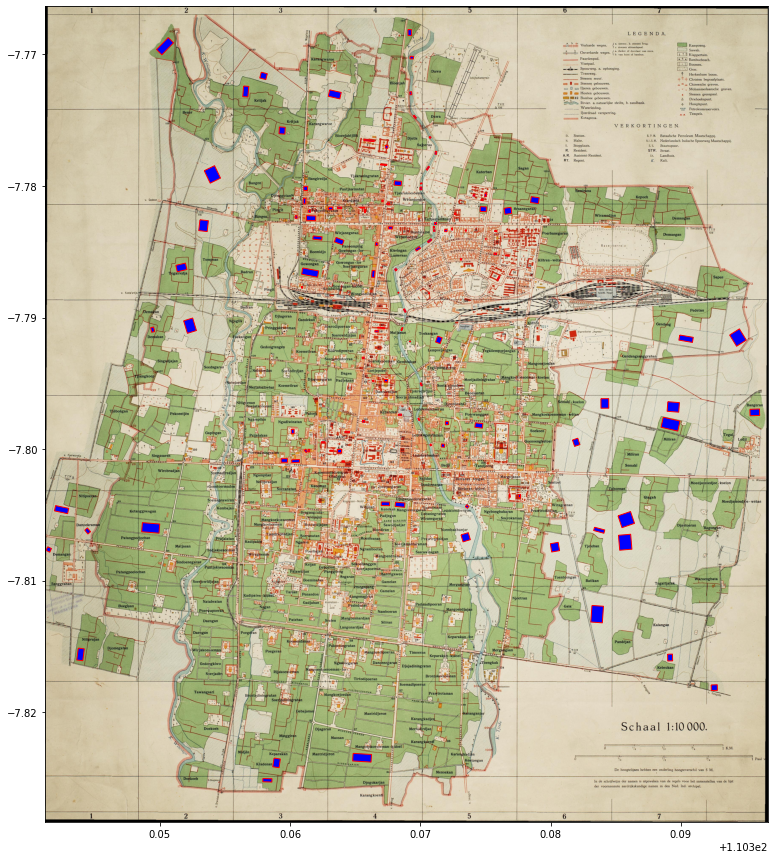

In [40]:
# plot training data and image
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(clippedsrc, ax=ax)
training.plot(ax=ax, facecolor='blue', edgecolor='r');

In [41]:
# jumlah data
len(training)

120

In [42]:
X = np.array([], dtype=np.int8).reshape(0,4) # pixels for training
y = np.array([], dtype=np.string_) # labels for training

In [57]:
# saving geometry values
geoms = training.geometry.values 

# extract the raster values within the polygon 
with rasterio.open("jogja_clipped.tif") as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True) 
        # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[training["class"][index]] * out_image_reshaped.shape[0]) 
        # stack the pizels onto the pixel array
        X = np.vstack((X,out_image_reshaped))        


In [58]:
# What are our classification labels?
labels = np.unique(training["class"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

The training data include 5 classes: ['1' '2' '3' '4' '5']

Our X matrix is sized: (164220, 4)
Our y array is sized: (164220,)


### Plot to check

Text(0.5, 1.0, 'Band Intensities Higher Ref Subset')

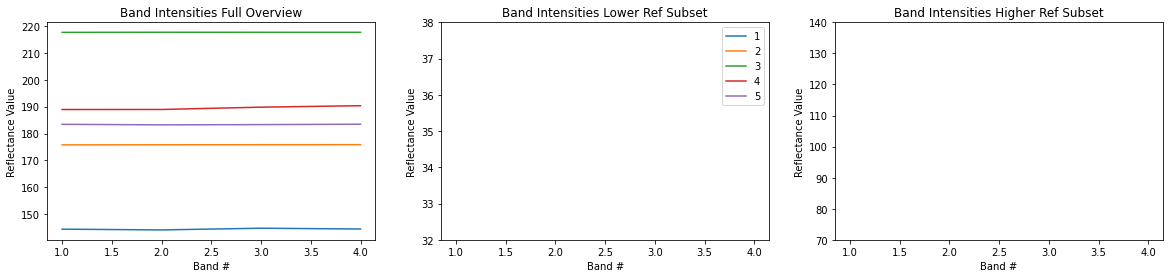

In [59]:
fig, ax = plt.subplots(1,3, figsize=[20,4])

# numbers 1-8
band_count = np.arange(1,5)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
    ax[1].plot(band_count, band_intensity, label=class_type)
    ax[2].plot(band_count, band_intensity, label=class_type)
# plot them as lines

# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')
#ax[0].set_ylim(32,38)
ax[1].set_ylim(32,38)
ax[2].set_ylim(70,140)
#ax.set
ax[1].legend(loc="upper right")
# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')

### Train


In [60]:
#from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [61]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

In [62]:
with rasterio.open("jogja_clipped.tif") as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read() #[:, 150:600, 250:1400]

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

(4, 3815, 3414)
(3815, 3414, 4)


In [63]:
class_prediction = gnb.predict(reshaped_img.reshape(-1, 4))
#class_prediction = gnb.predict(reshaped_img)
print(class_prediction)

# Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

['1' '1' '1' ... '1' '1' '1']


In [64]:
class_prediction

array([['1', '1', '1', ..., '1', '1', '1'],
       ['1', '1', '1', ..., '1', '1', '1'],
       ['1', '1', '1', ..., '1', '1', '1'],
       ...,
       ['1', '1', '1', ..., '1', '1', '1'],
       ['1', '1', '1', ..., '1', '1', '1'],
       ['1', '1', '1', ..., '1', '1', '1']], dtype='<U1')

In [65]:
def str_class_to_int(class_array):
    class_array[class_array == '1'] = 1
    class_array[class_array == '2'] = 2
    class_array[class_array == '3'] = 3
    class_array[class_array == '4'] = 4
    class_array[class_array == '5'] = 5
    return(class_array.astype(int))

class_prediction = str_class_to_int(class_prediction)

### Convert prediction to raster

(3815, 3414)


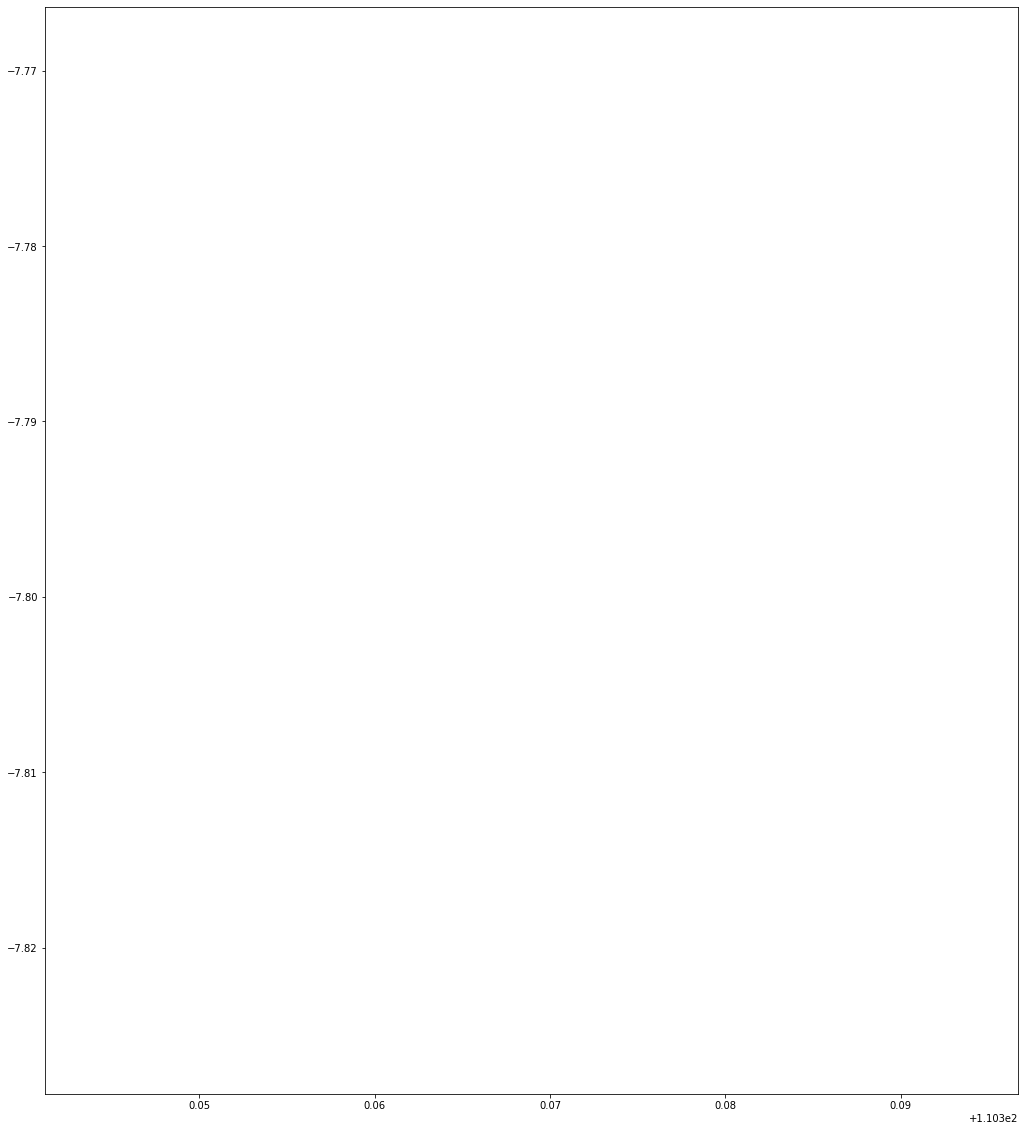

In [66]:
arr = class_prediction.astype('uint8')
print(arr.shape)
clippedsrc = rasterio.open("jogja_clipped.tif")

# update metadata for writing
out_meta.update({"driver": "GTiff",
                 "height": arr.shape[0],
                 "width": arr.shape[1],
                 "crs":clippedsrc.crs,
                 "transform": clippedsrc.transform})

# write the clipped image
with rasterio.open("classified.tif", "w", **out_meta) as dest:
    dest.write(arr, 1)

# show clipped map
classifiedsrc = rasterio.open("classified.tif")
show(classifiedsrc.read(), transform=classifiedsrc.transform)



In [67]:
arr


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

### Convert to Polygon

In [71]:
from shapely.geometry import Polygon
polygon = Polygon(class_prediction)
print(polygon.wkt)

AssertionError: ignored

### Display classification result

In [69]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (48, 156, 214, 255)),   # Blue - Water
    (1, (139,69,19, 255)),      # Brown - WetSand
    (2, (96, 19, 134, 255)),    # Purple - Emergent Wetland
    (3, (244, 164, 96, 255)),   # Tan - Sand
    (4, (206, 224, 196, 255)),  # Lime - Herbaceous
    (5, (34, 139, 34, 255)),    # Forest Green - Forest 
))

# Put 0 - 255 as float 0 - 1
for k in colors:
  v = colors[k]
  _v = [_v / 255.0 for _v in v]
  colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
    (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

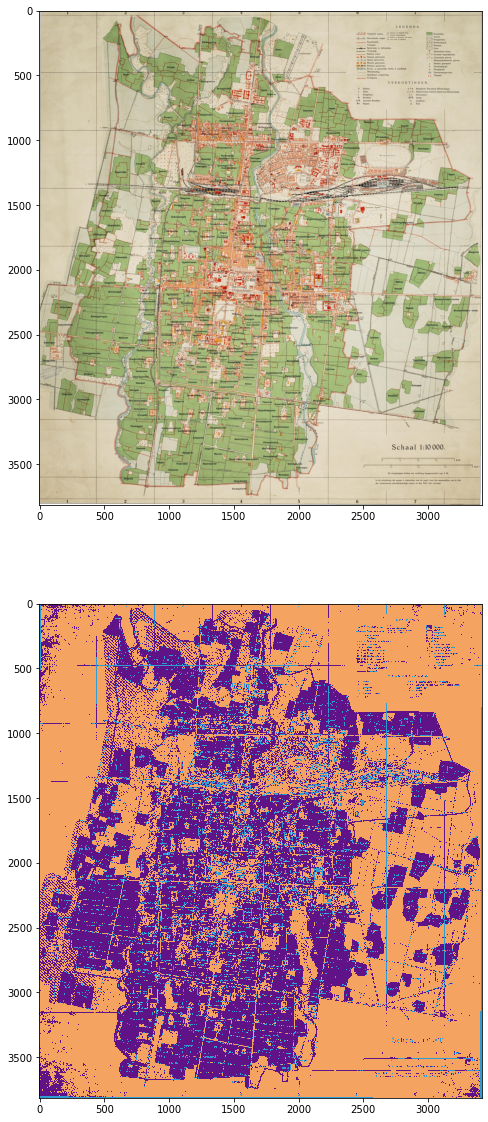

In [70]:
fig, axs = plt.subplots(2,1,figsize=(50,20))

img_stretched = color_stretch(reshaped_img, [1, 2, 3])
axs[0].imshow(reshaped_img)

axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')

fig.show()